In [9]:
#Step 1: Select A corpus 
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.corpus import gutenberg
nltk.download('inaugural')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import inaugural
names = inaugural.fileids()
corpus = inaugural.raw(fileids = names[0])

#Step 2. Preprocess corpus 20pts
def norm(text):
  norm_text = []
  tokenizer = RegexpTokenizer('[a-zA-Z]+')
  tokens_sentences = [tokenizer.tokenize(t) for t in sent_tokenize(text)]
  stop_words = stopwords.words('english')
  for s in tokens_sentences:
    w_norm = []
    for w in s:
      if not w.lower() in stop_words:
        w_norm.append(w.lower())
        norm_text.append(' '.join(w_norm))
  return(norm_text)

norm_corpus = norm(corpus)

[nltk_data] Downloading package inaugural to /root/nltk_data...
[nltk_data]   Package inaugural is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
#Step 3. Vocabulary 10pts
from keras.preprocessing import text
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_corpus)
word2id = tokenizer.word_index
word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_corpus]






In [3]:
#Step 4 generate a context window
#pass in the nomralized corpus 
from keras.utils import np_utils
from keras.preprocessing import sequence
import numpy as np

def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield (x, y)

# Apply to our wids and intialize and assign embed and vocab size  
i = 0
vocab_size = len(word2id)
embed_size = 100
window_size = 2
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]][:20], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
        i = i + 1
    
        if i == 5:
            break


Context (X): ['fellow', 'citizens', 'house', 'representatives'] -> Target (Y): senate
Context (X): ['fellow', 'citizens', 'house', 'representatives'] -> Target (Y): senate
Context (X): ['citizens', 'senate', 'representatives', 'among'] -> Target (Y): house
Context (X): ['fellow', 'citizens', 'house', 'representatives'] -> Target (Y): senate
Context (X): ['citizens', 'senate', 'representatives', 'among'] -> Target (Y): house


In [4]:
#@title Default title text { vertical-output: true }
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda
#Step 5. CBOW 10pts Build CBOW Model
cbow = Sequential()
vocab_size = len(word2id)
embed_size = 100
window_size = 2
cbow.add(Embedding(input_dim=vocab_size,output_dim=embed_size,input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,)))
cbow.add(Dense(vocab_size, activation="softmax"))
cbow.compile(loss='categorical_crossentropy', optimizer="rmsprop")


In [5]:

#Step 6. Training 10pts
for epoch in range(1, 6):
    loss = 0.
    i = 0
    for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
        i += 1
        loss += cbow.train_on_batch(x, y)
        if i % 100000 == 0:
            print('Processed {} (context, word) pairs'.format(i))

    print('Epoch:', epoch, '\tLoss:', loss)
    print()





Epoch: 1 	Loss: 63163.028626512736

Epoch: 2 	Loss: 40518.86806931067

Epoch: 3 	Loss: 30894.921437557437

Epoch: 4 	Loss: 24966.858082508465

Epoch: 5 	Loss: 20854.41570672903



In [7]:

#Step 7. Search Terms 20pts Get word embeddings 
from sklearn.metrics.pairwise import euclidean_distances
import pandas as pd
weights = cbow.get_weights()[0]
weights = weights[1:]
pd.DataFrame(weights, index=list(id2word.values())[1:]).head()
distance_matrix = euclidean_distances(weights)
similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-
1].argsort()[1:6]+1]
for search_term in ['every', 'public', 'since']}

Total words: 18 	Word Embedding shapes: (18, 100)


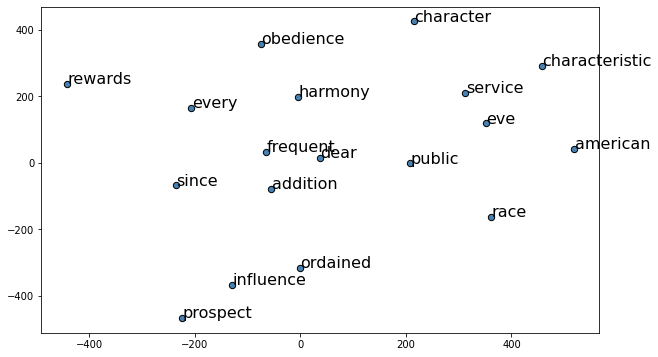

In [32]:
#Step 8. Visualization 10pts
from sklearn.manifold import TSNE
import pylab as plt
words = sum([[k] + v for k, v in similar_words.items()], [])
words_ids = [word2id[w] for w in words]
word_vectors = np.array([weights[idx] for idx in words_ids])
print('Total words:', len(words), '\tWord Embedding shapes:', word_vectors.shape)
tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors)
labels = words
plt.figure(figsize=(10, 6))
plt.scatter(T[:, 0], T[:, 1], c="steelblue", edgecolors="k", s= 40)
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
  plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points', fontsize = 16)  

#Write  a brief summary, describe your decisions on cleaning and preprocessing corpus
We have used a massive textual corpora from inaugural and preprocessed the corpus, cleaned the corpus from stopwords, and punctutation. Cleaning steps were taken to standardise the imported corpus text and to remove punctuation text, stop words, and lower cased. This was done using the regex tokenizer and sent_tokenize from ntlk tokenizer, to tokenize the corpus into tokens. After performing these steps a ‘clean’ text dataset was returned to be analysed using the below steps.

Created a vocabulary of possible words and generated dense word embeddings for each word in the vector space, then represented that vocabulary in a context windown. Using the w2id with a specified embed size of 100 and window size of 2 to build the CBOW model which was then  trained using 5 epoch. The word embeddings were extracted and a sample was created with 3 search terms. Visualizztion distance of the terms was plotted using plt from PyLab.

There are different model architectures which can be leveraged by Word2Vec to create these word embedding representations. In this assignmment the CBOW model was utilized.







#Proper references/citations

“Implementing Deep Learning Methods and Feature Engineering for Text Data: The Continuous Bag of Words (CBOW).” KDnuggets, www.kdnuggets.com/2018/04/implementing-deep-learning-methods-feature-engineering-text-data-cbow.html. 

PART 1. Word Embedding
Advanced Features PPT
Ch.4 Text Analytics with Python. Dipanjan Sarkar. 2019. Apress
An implementation guide to word2vec. Derek Chia. 2018
R Machine Learning Projects. Sunil Chinnamgari. 2018. Packt